- load hi and Jij
- construct graph with Jij on the edges of a fully connected graph


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from pairwise.src.pairwise_fitter import Pairwise_fitter
from pairwise.src.pairwise_evaluator import Pairwise_evaluator
import importlib
import src.paper_utils as utils
import src.plot as myplot
import pairwise.src.pairwise_utils as pwutils
import networkx as nx

In [2]:
importlib.reload(myplot)
importlib.reload(utils)
importlib.reload(pwutils)

<module 'pairwise.src.pairwise_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots_pw/../../pairwise/src/pairwise_utils.py'>

In [51]:
# ACE
nspin = 121
model_digits = [0,1]
sample_sizes = [4000]
testdatas = [np.genfromtxt(utils.load_test_data(digit), dtype=int, delimiter=1) for digit in model_digits]
outdir = "../data/OUTPUT/pairwise/OUTPUT_mod"
pw_mods = [pwutils.get_pw_mod(i,nspin,outdir) for i in model_digits] # both models were stopped after 100 iterations of the ACE algorithm, 4k samples


In [4]:
# # RISE
# outdir = "../data/OUTPUT/pairwise/OUTPUT_mod"
# outdir = f"../data/OUTPUT/pairwise/OUTPUT_mod_rise/train/{sample_sizes[0]}/1" #first run

# fe = f"_rise_julia.dat"

# pw_mods = [pwutils.get_pw_mod(i,nspin,outdir, fileend=fe) for i in model_digits] # both models were stopped after 100 iterations of the ACE algorithm, 4k samples


In [5]:

def gen_edgelist(nspin):
    """Generate edges of the graph of a pairwise model with nspin variables.

    :param nspin: number of spins in the system
    :type nspin: int
    :return: list of 2-tuples of integers of the nodes
    :rtype: list of len nspin(nspin-1)/2
    """
    G = nx.complete_graph(nspin)
    edgelist = list(G.edges())
    return edgelist


def build_graph(pw_model):
    """Build graph based on pairwise model.

    :param pw_model: Pairwise model fitted on some data.
    :type pw_model: pairwise.src.pairwise_evaluator.Pairwise_evaluator object
    :return: graph of pairwise model. Couplings (Jij) are edge weightes. Fields (hij) are ignored.
    :rtype: _type_
    """
    edges = gen_edgelist(121)
    weighted_edges = [tuple(i) for i in np.c_[edges, pw_model.couplings]]
    G = nx.Graph(edges)
    G.add_weighted_edges_from(weighted_edges)
    return G


def cluster_partmap(G,seed, return_lcom = False):
    """Cluster the graph using the louvain algorithm and return the 11x11 parition map

    :param G: graph of pairwise model
    :type G: nx.Graph() object
    :return: parition map of the 11x11 image and integer labels
    :rtype: np.array of shape (11,11)
    """
    lcom = nx.community.louvain_communities(G, seed=seed)

    pmap = np.empty((121),dtype=int)

    for i,pixels in enumerate(lcom):
        pmap[list(pixels)] = i

    if return_lcom:
        return pmap.reshape((11,11)), lcom
    return pmap.reshape((11,11))

In [194]:
dig = 0
pwm = pw_mods[dig]
G = build_graph(pwm)

In [195]:
def community_avgJij(G,com,return_all=False):
    sub_G = G.subgraph(com)

    def get_edge_attributes(G, name="weight"):
        edges = G.edges(data=True)
        return [x[-1][name] for x in edges if name in x[-1]]
    
    comm_w = get_edge_attributes(sub_G,"weight")
    if return_all:
        return comm_w
    if comm_w:
        return np.nanmean(comm_w)
    else: return 0


/var/folders/z9/j9843dsj2t5dsl2bv81xcwww0000gn/T/ipykernel_59965/1913489664.py:3: RuntimeWarning: divide by zero encountered in log
  lcomm_w_log = np.where(np.array(lcomm_w) != 0, np.log(np.array(lcomm_w)), 0)


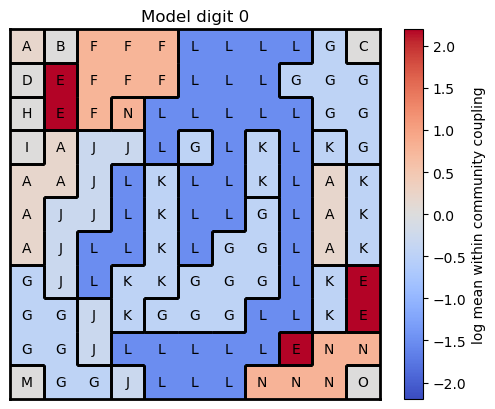

In [196]:
pmap,lcom = utils.cluster_partmap(G,42,return_lcom=True)
lcomm_w = np.array([utils.community_avgJij(G, com) for com in lcom])
lcomm_w_log = np.where(np.array(lcomm_w) != 0, np.log(np.array(lcomm_w)), 0)
plt.title(f"Model digit {dig}")
im = myplot.partition_map(plt.gca(),np.array(lcomm_w_log)[pmap],myplot.int_to_letters(pmap),myplot.find_borders(pmap),cbar=None)
colorbar = plt.colorbar(im,label="log mean within community coupling")

In [198]:
# take community pixels, and extract fields and within community couplings
# then just steal these 3 functions (energy, couplings, fields) here and change their arguments
# then provide the states this community sees and calculate energy
# do for all states in training data and compute average
# do this for all communities
# """Compute -1*sum(J_ij*s[i]*s[j]) for all (i,j) with i < j.

importlib.reload(utils)
import os

examp_com = lcom[16]


def add_data_and_field_attr_G(G,pw_model, dig, outdir="../data/OUTPUT/pairwise/OUTPUT_mod",fname="train-images-unlabeled-{}"):
    fname = fname.format(dig)
    datpath = os.path.join(outdir,fname,fname+"_sep.dat")
    dat = np.loadtxt(datpath)
    
    attrs = {i: {"field": pw_model.fields[i], "spin_states": dat[:,i]} for i in range(121)}
    nx.set_node_attributes(G, attrs)
    return G

G = add_data_and_field_attr_G(G, pw_mods[1], 1)


def E_subgraph_avg(G, com_i):


    sub_G = G.subgraph(com_i)

    mapping_jij = nx.get_edge_attributes(sub_G,"weight")
    spin_states  = nx.get_node_attributes(sub_G,"spin_states")

    pairs = list(mapping_jij.keys())
    # then iterate over coupling pairs (edges)
    coup = []
    for pair in pairs:
        jij = mapping_jij[pair]
        coup.append(spin_states[pair[0]] * spin_states[pair[1]] * jij)
    E_coupling = np.array(coup).sum(axis=0)

    subG_singlespin_states = np.array(list(nx.get_node_attributes(sub_G,"spin_states").values()))
    subG_h = np.array(list(nx.get_node_attributes(sub_G, "field").values()))
    E_field = (subG_singlespin_states.T * subG_h).sum(axis=1) # sum over spins, mean over samples
    subG_E = np.mean(-1*(E_field + E_coupling))
    return subG_E



# E_subgraph_avg(G, lcom[16]) # lcom is a set of indices in the image of the label given by the index e.g., lcom[16]
# maybe only take the mean when have the energy

IndexError: list index out of range

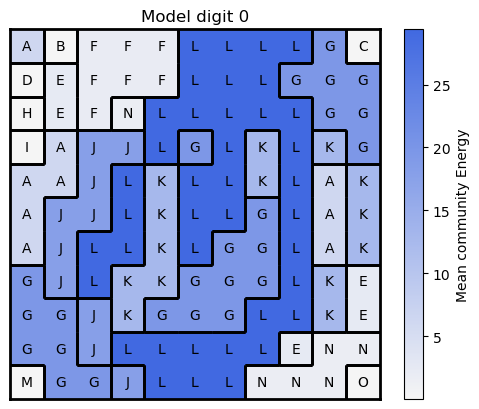

In [199]:
cmap = myplot.cmap_to_gray("royalblue", reverse=True)
G = add_data_and_field_attr_G(G, pw_mods[dig], dig)
commE_map = np.array([E_subgraph_avg(G, lc) for lc in lcom])[pmap]
# pmap,lcom = utils.cluster_partmap(G,42,return_lcom=True)
# lcomm_w = np.array([utils.community_avgJij(G, com) for com in lcom])
# lcomm_w_log = np.where(np.array(lcomm_w) != 0, np.log(np.array(lcomm_w)), 0)
plt.title(f"Model digit {dig}")
im = myplot.partition_map(plt.gca(), commE_map,myplot.int_to_letters(pmap),myplot.find_borders(pmap),cbar=None, normalise=False, cmap=cmap)
colorbar = plt.colorbar(im,label="Mean community Energy")

In [ ]:

# 


# pw_mods[1].fields.reshape((11,11))

# def build_graph(pw_model):
#     """Build graph based on pairwise model.

#     :param pw_model: Pairwise model fitted on some data.
#     :type pw_model: pairwise.src.pairwise_evaluator.Pairwise_evaluator object
#     :return: graph of pairwise model. Couplings (Jij) are edge weightes. Fields (hij) are ignored.
#     :rtype: _type_
#     """
#     edges = gen_edgelist(121)
#     weighted_edges = [tuple(i) for i in np.c_[edges, pw_model.couplings]]
#     G = nx.Graph(edges)
#     G.add_weighted_edges_from(weighted_edges)

#     return G

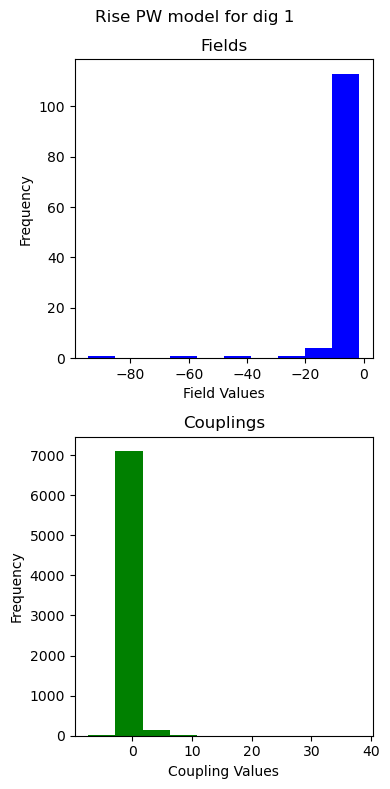

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8))

# Plot histogram for fields
ax1.hist(pw_mods[dig].fields, bins=10, color='blue')
ax1.set_title('Fields')
ax1.set_xlabel('Field Values')
ax1.set_ylabel('Frequency')

# Plot histogram for couplings
ax2.hist(pw_mods[dig].couplings, bins=10, color='green')
ax2.set_title('Couplings')
ax2.set_xlabel('Coupling Values')
ax2.set_ylabel('Frequency')
fig.suptitle(f"Rise PW model for dig {dig}")
plt.tight_layout()
plt.show()


In [10]:
raise KeyboardInterrupt

KeyboardInterrupt: 

---------------------

In [ ]:
# only select top k edges in graph
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:

# # Calculate the threshold value for the top 1% largest edges
# threshold = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[int(len(G.edges) * 0.01)][2]['weight']


# top_edges_w = [(u, v,d) for u, v, d in G.edges(data=True) if d['weight'] >= threshold]
# G_top = nx.Graph(top_edges_w, with_labels=False, node_size=.1)
# # nx.draw(G_top, node_size=.1)

# edges,weights = zip(*nx.get_edge_attributes(G_top,'weight').items())

# # pos = nx.spring_layout(G_top)
# # nx.draw(G_top, pos, node_color='b', edgelist=edges, edge_color=weights, width=1.0, edge_cmap=plt.cm.viridis,node_size=.1 )
